In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import sys
import yfinance as yf

from tqdm.notebook import tqdm
sys.path.insert(0,'/Users/orentapiero/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2
from btc_functions.wavelet_transform import WT

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
set_loky_pickler()

tqdm.pandas()
plt.rcParams['figure.figsize'] = [10,7]
sns.set()

In [2]:
# tickers = ['BTC-USD','QQQ']

# ohlc = dict()
# mid_prices = []

# for ticker in tickers:
#     tkr = yf.Ticker(ticker)
#     ohlc[ticker] = tkr.history(period="max")
#     mid_prices.append(ohlc[ticker][['High','Low']].mean(1).rename(ticker))
    
# mid_prices = pd.concat(mid_prices,axis = 1).dropna()
# log_returns = 100*np.log(mid_prices).diff().dropna()

In [3]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})

sam_list = ['puell_multiple', 'sopr_adjusted', 'reserve_risk', 'cdd90_age_adjusted', 
            'average_dormancy', 'liveliness', 'net_unrealized_profit_loss', 'realized_profit_loss_ratio', 
            'realized_profits_to_value_ratio', 'rhodl_ratio', 'cvdd', 'nvts', 
            'marketcap_thermocap_ratio', 'difficulty_latest' ,'mvrv_z_score', 
            'non_zero_count']

features = get_glassnode_data(sam_list,Urls)
data = pd.concat([ohlc[['Open','High','Low','Close']].mean(1).rename('price'),features],axis = 1).dropna()

  0%|          | 0/16 [00:00<?, ?it/s]

In [4]:
def check_stationarity(y):
    y_ = y[~np.isnan(y)]
    test = adfuller(y_)
    pvalue = test[1]
    
    if pvalue<0.1:
        y = y.copy()
    else:
        y = np.diff(y,prepend=np.nan)
        
    return y,pvalue

def check_stationarity_transform(x,niter = 3):
    y = x.copy()
    
    for i in range(niter):
        y,pvalue = check_stationarity(y)
        if pvalue<0.1:
            break
            
    return y,i

def Lag(x,L):
    Lx=np.empty_like(x)
    Lx[:]=np.nan
    Lx[L:]=x[:-L]
    return Lx

def create_ar(x,order):
    AR = [x]
    for l in order:
        AR.append(Lag(x,l))
    AR = np.vstack(AR).T
    return AR

def np_dropna(X):
    return X[~np.isnan(X).any(axis=1)]

def scaleX(X):
    try:
        return StandardScaler().fit(X)
    except:
        return StandardScaler().fit(X.reshape(-1,1))

def scaleY(y):
    return StandardScaler().fit(y.reshape(-1,1))

def svr_fit_predict(Y):
    svr = SVR()
    y,X,Xcv = Y[:,0],Y[:,1:],Y[-1,:-1]

    scale_y,scale_X = scaleY(y),scaleX(X)
    ys,Xs,Xs_cv = scale_y.transform(y.reshape(-1,1)),scale_X.transform(X),scale_X.transform(Xcv.reshape(1,-1))

    svr.fit(Xs,ys.ravel())
    
    error = y-scale_y.inverse_transform(svr.predict(Xs).reshape(-1,1)).ravel()
    predicted = scale_y.inverse_transform(svr.predict(Xs_cv[0].reshape(1,-1)).reshape(1,-1))[0][0]
    return predicted,error

def kde_quantile(kde,q):
    x = np.arange(-10,10,step = 0.001)
    f = np.exp(kde.score_samples(x.reshape(-1,1)))

    xf = np.vstack([x,f]).T
    xf = xf[np.argsort(xf[:, 0])]

    abs_q = np.abs((xf[:,1]*0.001).cumsum()-q)
    qtl = xf[np.where(abs_q == np.min(abs_q))[0],0]
    return qtl[0]

def to_dataframe(output):
    out = pd.DataFrame(output)
    out.index = pd.to_datetime(out.iloc[:,0])
    return out.iloc[:,1:]


In [5]:
options = dict(svr_C = 10.0,svr_epsilon = 0.2,svr_kernel = 'rbf',
               kde_kernel = 'gaussian',bandwidth = 0.75,
               quantiles = (0.05,0.25,0.5,0.75,0.95))


In [6]:
np.set_printoptions(precision=3)

def rolling_svr_wavelet(mid_prices,dates,order = (1,2,3,4)):
    px = mid_prices.loc[dates].values
    out = dict(date = dates[-1],price = px[-1],dP = px[-1]-px[-2])
               
    coeffs = WT(px, wavefunc='db5', lv=4, m=4, n=4, plot=False)
    Nc = len(coeffs)
    
    
    Fcast = []
    
    for j in range(Nc):
        y,diff_order = check_stationarity_transform(coeffs[j])
        ar_y = create_ar(y,order)
        Y = np_dropna(ar_y)
        pred,error = svr_fit_predict(Y)

        if diff_order > 1:
            prediction = (coeffs[0][-1]-coeffs[0][-2]) + pred
        else:
            prediction = pred
            
        Fcast.append(prediction)
        out['c_'+str(j)] = prediction
    
    out['prediction'] = np.mean(Fcast)
    
    return out

def hit_ratio(output):
    mask = (output.dP > 0) & (output.prediction.shift(1) > 0)
    mask = mask | ((output.dP <= 0) & (output.prediction.shift(1) <= 0))
    return mask.sum()/len(mask)


# kde = KernelDensity(kernel=options['kde_kernel'],bandwidth=options['bandwidth']).fit(error.reshape(-1,1))
# Quantile = np.array([kde_quantile(kde,q) for q in options['quantiles']])
# Qtl = predicted+error.std()*Quantile


In [7]:
price =data['price']

strided_date = strided_app(price.index.values,500,1)
order = (1,2,3,4)

T = strided_date.shape[0]
iterate = tqdm(range(T))
fun = delayed(rolling_svr_wavelet)
output = Parallel(n_jobs=-1)(fun(price,strided_date[t,:],order) for t in iterate)
output = to_dataframe(output)

print('hit ratio:',hit_ratio(output))

  0%|          | 0/2833 [00:00<?, ?it/s]

hit ratio: 0.5647723261560184


<AxesSubplot:xlabel='date'>

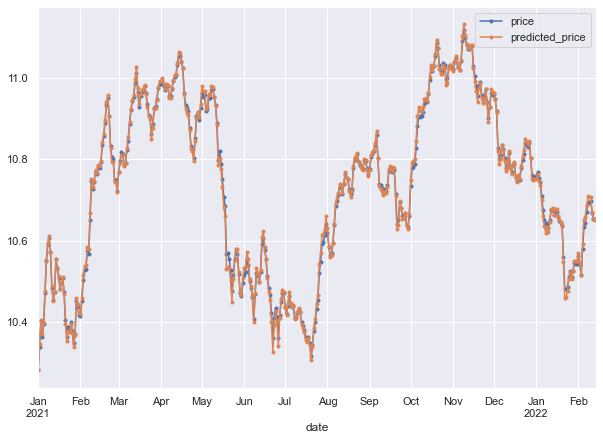

In [8]:
output['predicted_price'] = output['price']+output['prediction']
np.log(output[['price','predicted_price']]).loc['2021':].plot(style='.-')

In [9]:
def svr_fit_predict1(y,X,Xcv):
    svr = SVR()    
    
    
    scale_y,scale_X = scaleY(y),scaleX(X)
    ys,Xs,Xs_cv = scale_y.transform(y.reshape(-1,1)),scale_X.transform(X),scale_X.transform(Xcv.reshape(1,-1))

    svr.fit(Xs,ys.ravel())    
    error = y-scale_y.inverse_transform(svr.predict(Xs).reshape(-1,1)).ravel()
    predicted = scale_y.inverse_transform(svr.predict(Xs_cv[0].reshape(1,-1)).reshape(1,-1))[0][0]
            
    return predicted,error


In [10]:
def rolling_svr_wavelet1(data,dates,order = (1,2,3,4)):
    mat = data.loc[dates].values

    px = mat[:,0]
    Xmat = mat[:,1:]
    Nk = Xmat.shape[1]

    Xmat_ = []
    for k in range(Nk):
        x_,diff_order = check_stationarity_transform(Xmat[:,k].astype(float))
        Xmat_.append(x_)

    Xmat_ = np.vstack(Xmat_).T 
    LXmat_ = np.empty_like(Xmat_)
    LXmat_[:] = np.nan
    LXmat_[1:,:] = Xmat_[:-1,:]

    out = dict(date = dates[-1],price = px[-1],dP = px[-1]-px[-2])
    coeffs = WT(px, wavefunc='db4', lv=4, m=4, n=4, plot=False)
    Nc = len(coeffs)


    Fcast = []

    for j in range(Nc):
        y,diff_order = check_stationarity_transform(coeffs[j])
        ar_y = create_ar(y,order)
        all_ = np.vstack([ar_y.T,LXmat_.T]).T
        all_ = np_dropna(all_)

        y = all_[:,0]
        X = all_[:,1:]
        Xcv1 = [y[-i] for i in order]
        Xcv2 = list(Xmat_[-1,:])
        Xcv = np.array(Xcv1+Xcv2)

        pred,error = svr_fit_predict1(y,X,Xcv)

        if diff_order > 1:
            prediction = (coeffs[0][-1]-coeffs[0][-2]) + pred
        else:
            prediction = pred

        Fcast.append(prediction)
        out['c_'+str(j)] = prediction

    out['prediction'] = np.mean(Fcast)

    return out

In [11]:
strided_date = strided_app(data.index.values,500,1)
order = (1,2,3,4)

T = strided_date.shape[0]
iterate = tqdm(range(T))
fun = delayed(rolling_svr_wavelet1)
output = Parallel(n_jobs=-1)(fun(data,strided_date[t,:],order) for t in iterate)
output = to_dataframe(output)

print('hit ratio:',hit_ratio(output))

  0%|          | 0/2833 [00:00<?, ?it/s]

hit ratio: 0.5728909283445112


<AxesSubplot:xlabel='date'>

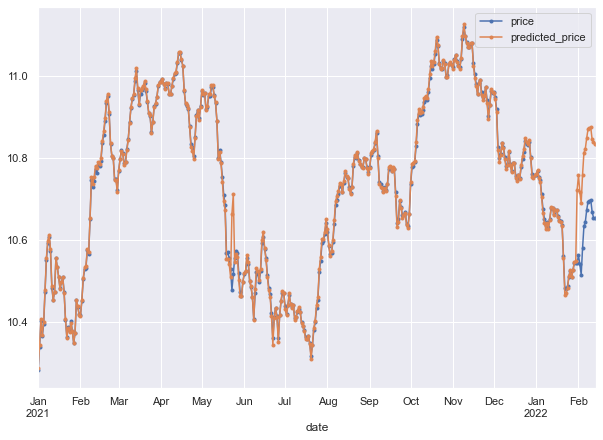

In [12]:
output['predicted_price'] = output['price']+output['prediction']
np.log(output[['price','predicted_price']]).loc['2021':].plot(style='.-')

In [32]:
from backtesting import Backtest, Strategy


class Signal_Trade(Strategy):
    def init(self):
        signal = np.sign(self.data.prediction)
        self.signal = signal

    def next(self):
        if (self.signal==1): # and not (self.position.is_long):
            self.buy(size=.9)
        elif (self.signal==-1): #and not (self.position.is_short):
             self.sell(size=.9)

ohlc1 = pd.concat([ohlc,output.prediction],axis=1).dropna()
ohlc1['Volume'] = 1e6

bt = Backtest(ohlc1.loc['2015':], Signal_Trade, commission=.0002,
              cash = 1000000,exclusive_orders=True,hedging=True,
              trade_on_close=True)

stats = bt.run()
stats

Start                     2015-01-01 00:00:00
End                       2022-02-14 00:00:00
Duration                   2601 days 00:00:00
Exposure Time [%]                   99.923136
Equity Final [$]              62159968.306505
Equity Peak [$]               95411463.988126
Return [%]                        6115.996831
Buy & Hold Return [%]            13466.325346
Return (Ann.) [%]                   78.479275
Volatility (Ann.) [%]              134.244965
Sharpe Ratio                         0.584598
Sortino Ratio                        1.722778
Calmar Ratio                         0.970718
Max. Drawdown [%]                  -80.846606
Avg. Drawdown [%]                  -11.168581
Max. Drawdown Duration     1097 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                 2600
Win Rate [%]                        53.884615
Best Trade [%]                      25.346272
Worst Trade [%]                    -38.588457
Avg. Trade [%]                    

In [33]:
bt.plot()


Row(id='4168', ...)

<AxesSubplot:>

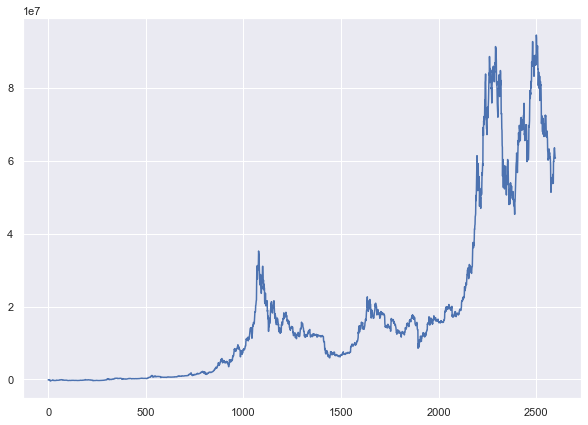

In [36]:
bt._results._trades['PnL'].cumsum().plot()